# Time series forecasting using Holt-Winters 
### Import necessary libraries

In [1]:
%matplotlib notebook

import numpy
import pandas
import datetime
import sys
import time
import matplotlib.pyplot as ma
import statsmodels.tsa.holtwinters as hw


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Load necessary CSV file

In [2]:
try: 
    ts = pandas.read_csv('../../datasets/srv-1-art-5m.csv')
except:
    print("I am unable to connect to read .csv file", sep=',', header=1)

ts.index = pandas.to_datetime(ts['ts'])

# delete unnecessary columns
del ts['id']
del ts['ts']
del ts['min']
del ts['max']
del ts['sum']
del ts['cnt']
del ts['p50']
del ts['p95']
del ts['p99']

# print table info
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23727 entries, 2018-04-11 19:10:00 to 2018-07-16 11:45:00
Data columns (total 1 columns):
avg    23727 non-null int64
dtypes: int64(1)
memory usage: 370.7 KB


### Get values from specified range

In [3]:
ts = ts['2018-06-16':'2018-07-15']

### Remove possible NA values (by interpolation)
NA values are explicitely removed by linear interpolation.

In [4]:
def print_values_stats():
    print("Zero Values:\n",sum([(1 if x == 0 else 0) for x in ts.values]),"\n\nMissing Values:\n",ts.isnull().sum(),"\n\nFilled in Values:\n",ts.notnull().sum(), "\n")

idx = pandas.date_range(ts.index.min(), ts.index.max(), freq="5min")
ts = ts.reindex(idx, fill_value=None)
print("Before interpolation:\n")
print_values_stats()
ts = ts.replace(0, numpy.nan)
ts = ts.interpolate(limit_direction="both")
print("After interpolation:\n")
print_values_stats()

Before interpolation:

Zero Values:
 0 

Missing Values:
 avg    99
dtype: int64 

Filled in Values:
 avg    8541
dtype: int64 

After interpolation:

Zero Values:
 0 

Missing Values:
 avg    0
dtype: int64 

Filled in Values:
 avg    8640
dtype: int64 



### Plot values

<IPython.core.display.Javascript object>


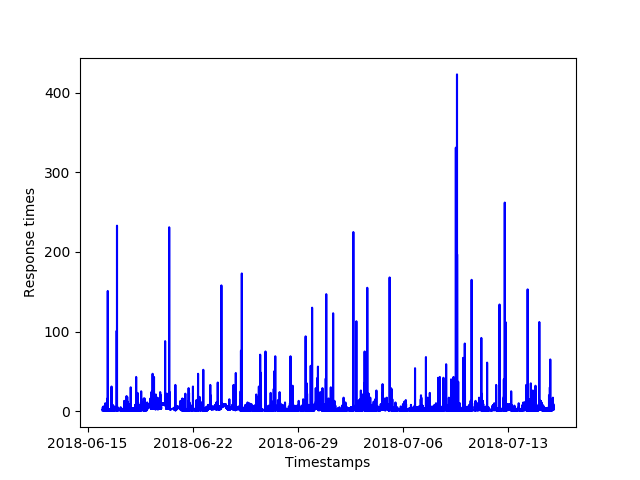

/usr/lib/python3/dist-packages/matplotlib/backend_bases.py:2445: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [5]:
# Idea: Plot figure now and do not wait on ma.show() at the end of the notebook
ma.ion()
ma.show()
fig1 = ma.figure(1)
ma.plot(ts, color="blue")
ma.xlabel("Timestamps")
ma.ylabel("Response times")
ma.draw()
try:
    ma.pause(0.001) # throws NotImplementedError, ignore it
except:
    pass

### Split time series into train and test series
We have decided to split train and test time series by two weeks.

In [6]:
train_data_length = 12*24*7
ts_train = ts[:train_data_length]
ts_test = ts[train_data_length+1:]

### Fit and predict Time Serie

In [7]:
def print_hw_parameters(model):
    alpha, beta, gamma = model.params['smoothing_level'], model.params['smoothing_slope'], model.params['smoothing_seasonal']
    print("Holt-Winters parameters:")
    print("Alpha: ", alpha)
    print("Beta: ", beta)
    print("Gamma: ", gamma)

print("Forecasting started...")
start_time = time.time()

try:
    model = hw.ExponentialSmoothing(ts_train, seasonal='additive', seasonal_periods=train_data_length-1).fit()
    predictions = model.predict(start=ts_test.index[0], end=ts_test.index[-1])
except Exception as e:
    print("Error during forecast: ", str(e))

print("Forecasting finished")
print("Time elapsed: ", time.time() - start_time)

print_hw_parameters(model)

Forecasting started...
Forecasting finished
Time elapsed:  56.358988523483276
Holt-Winters parameters:
Alpha:  0.15189682614562297
Beta:  0.0
Gamma:  0.0


### Count mean absolute percentage error
We use MAPE (https://www.forecastpro.com/Trends/forecasting101August2011.html) instead of MSE because the result of MAPE does not depend on size of values.

In [8]:
values_sum = 0
for value in zip(ts_test.values, predictions.values):
    actual = value[0]
    predicted = value[1]
    values_sum += abs((actual - predicted) / actual)

values_sum *= 100/len(predictions)
print("MAPE: ", values_sum, "%\n")

MAPE:  [212.60519694] %



### Plot forecasted values

<IPython.core.display.Javascript object>


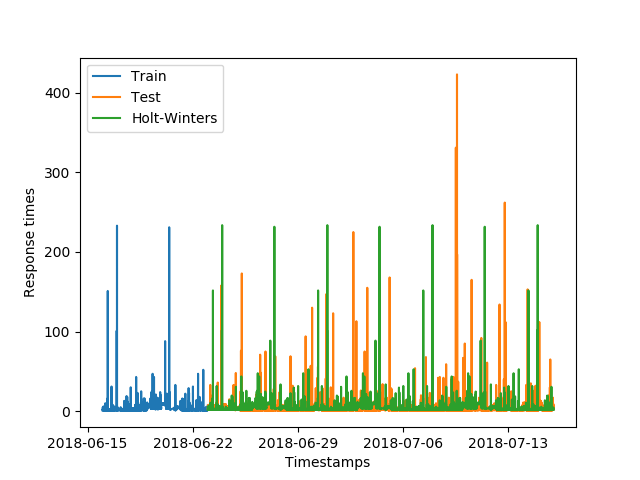

In [9]:
ma.figure(2)
ma.plot(ts_train.index, ts_train, label='Train')
ma.plot(ts_test.index, ts_test, label='Test')
ma.plot(predictions.index, predictions, label='Holt-Winters')
ma.xlabel("Timestamps")
ma.ylabel("Response times")
ma.legend(loc='best')
ma.draw()